# Data Analysis of bolt demand data

In [98]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np

import h3
import folium
from folium.plugins import HeatMap

from shapely.geometry import Polygon
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex

In [99]:
# variables
INPUT_FILE_PATH = '../processed_data/bolt_demand.pickle'

H3_RESOLUTION = 9

In [100]:
df = pd.read_pickle(INPUT_FILE_PATH)
df.head()

,bike_id,lat,lon,current_range_meters,current_fuel_percent,event_type,event_time_start_range,event_time_end_range
0,BLT:Vehicle:b6069f5c-58b8-4f69-9671-94b88988d4a0,48.708420,9.003853,10080.0,0.39,pickup,2025-02-11 14:39:37,2025-02-11 14:44:37
1,BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b,48.826118,9.238379,23800.0,0.44,pickup,2025-02-11 14:39:37,2025-02-11 14:44:37
2,BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e,48.748035,9.074088,22400.0,0.42,pickup,2025-02-11 14:39:37,2025-02-11 14:44:37
3,BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870,48.809673,9.183686,14000.0,0.30,pickup,2025-02-11 14:39:37,2025-02-11 14:44:37
4,BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5,48.741364,9.165754,46900.0,0.77,pickup,2025-02-11 14:39:37,2025-02-11 14:44:37


In [101]:
df['geometry'] = gpd.points_from_xy(df['lon'], df['lat'], crs="EPSG:4326")
df['h3_index'] = df.apply(lambda x: h3.latlng_to_cell(x['lat'], x['lon'], 8), axis=1)
# timestamp as mean of start range and end range
df['timestamp'] = pd.to_datetime(
    (df['event_time_start_range'].view(np.int64) + df['event_time_end_range'].view(np.int64)) // 2
)
df.drop(columns=['event_time_start_range', 'event_time_end_range'], inplace=True)
df.drop(columns=['lon', 'lat'], inplace=True)
df = gpd.GeoDataFrame(df, geometry='geometry')
df.head()

/tmp/ipykernel_3523649/380723335.py:5: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  (df['event_time_start_range'].view(np.int64) + df['event_time_end_range'].view(np.int64)) // 2


,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,h3_index,timestamp
0,BLT:Vehicle:b6069f5c-58b8-4f69-9671-94b88988d4a0,10080.0,0.39,pickup,POINT (9.00385 48.70842),881faa4c9bfffff,2025-02-11 14:42:07
1,BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b,23800.0,0.44,pickup,POINT (9.23838 48.82612),881faa718bfffff,2025-02-11 14:42:07
2,BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e,22400.0,0.42,pickup,POINT (9.07409 48.74804),881faa7b13fffff,2025-02-11 14:42:07
3,BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870,14000.0,0.30,pickup,POINT (9.18369 48.80967),881faa7133fffff,2025-02-11 14:42:07
4,BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5,46900.0,0.77,pickup,POINT (9.16575 48.74136),881faa78cdfffff,2025-02-11 14:42:07


## Temporal time bining

In [102]:
time_bins = [0, 5, 9, 13, 20]
time_labels = ['morning', 'midday', 'afternoon', 'evening']
df['time_bin'] = pd.cut(df['timestamp'].dt.hour, bins=time_bins, labels=time_labels, right=False)

In [103]:
pickup_demand = df[df['event_type'] == "pickup"].copy()
dropoff_demand = df[df['event_type'] == "dropoff"].copy()
pickup_demand.drop(columns=['event_type'], inplace=True)
dropoff_demand.drop(columns=['event_type'], inplace=True)
len(pickup_demand), len(dropoff_demand)

(197933, 197910)

In [104]:
# diplay pickup demand demand as a heatmap based on the h3 index
def display_as_heatmap(temp_df): 
    h3_counts = temp_df['h3_index'].value_counts().reset_index()
    h3_counts.columns = ['h3_index', 'count']

    h3_polygons = []
    for idx in h3_counts['h3_index']:
        polygon_geojson = h3.cell_to_boundary(idx)
        h3_polygons.append(polygon_geojson)

    h3_gdf = gpd.GeoDataFrame(
        h3_counts, 
        geometry=[
            Polygon([(p[1], p[0]) for p in poly]) 
            for poly in h3_polygons
        ],
        crs="EPSG:4326"
    )

    mean_lat_pickup = temp_df.geometry.apply(lambda p: p.y).mean()
    mean_lon_pickup = temp_df.geometry.apply(lambda p: p.x).mean()

    m_pickup = folium.Map(location=[mean_lat_pickup, mean_lon_pickup], zoom_start=11)


    def get_color(count, max_count):
        norm = Normalize(vmin=0, vmax=max_count)
        colormap = cm.get_cmap('viridis')
        rgba_color = colormap(norm(count))
        return to_hex(rgba_color)

    max_count = h3_gdf['count'].max()

    # Add hexagons to map
    for idx, row in h3_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row['count']: {
                'fillColor': get_color(count, max_count),
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"Count: {row['count']}"
        ).add_to(m_pickup)

    return m_pickup

In [105]:
display_as_heatmap(pickup_demand)

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [106]:
display_as_heatmap(dropoff_demand)

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [107]:
# morning pickup demand
display_as_heatmap(pickup_demand[pickup_demand['time_bin'] == 'morning'])

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [110]:
# midday pickup demand
display_as_heatmap(dropoff_demand[dropoff_demand['time_bin'] == 'midday'])

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [ ]:
# afternoon pickup demand
display_as_heatmap(pickup_demand[pickup_demand['time_bin'] == 'afternoon'])

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [ ]:
# evening pickup demand
display_as_heatmap(pickup_demand[pickup_demand['time_bin'] == 'evening'])

/tmp/ipykernel_3523649/1515056865.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


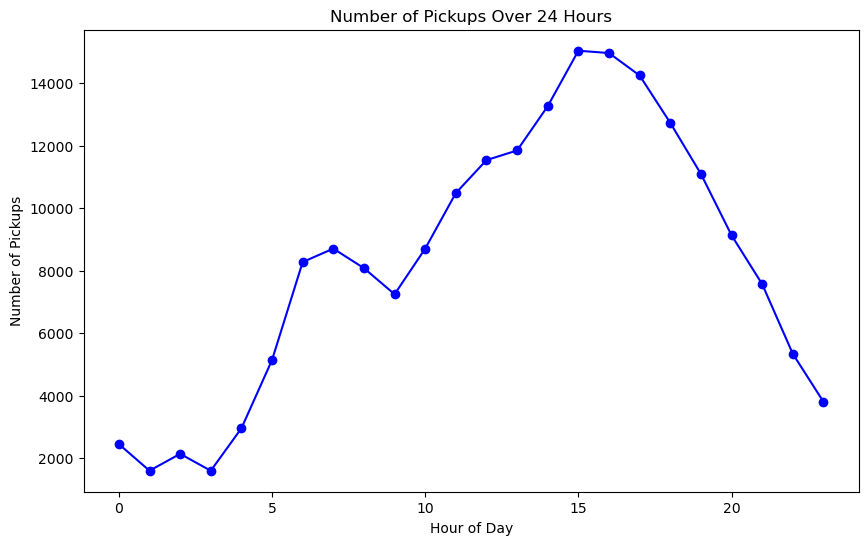

In [ ]:
# Group by hour and count pickups
pickup_hourly = pickup_demand['timestamp'].dt.hour.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(pickup_hourly.index, pickup_hourly.values, marker='o', linestyle='-', color='b')
plt.title('Number of Pickups Over 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.show()

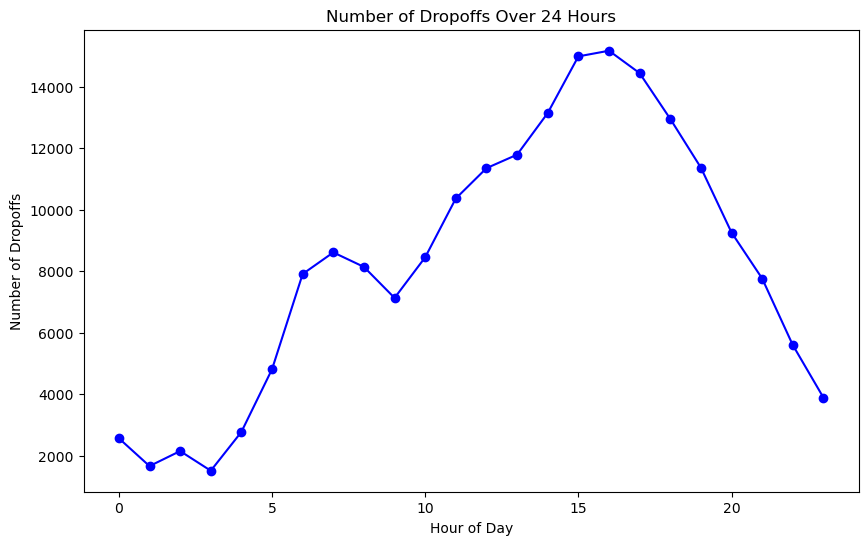

In [ ]:
# Group by hour and count dropoffs
dropoff_hourly = dropoff_demand['timestamp'].dt.hour.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dropoff_hourly.index, dropoff_hourly.values, marker='o', linestyle='-', color='b')
plt.title('Number of Dropoffs Over 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Dropoffs')
plt.show()